# P4 - Anticipez le retard de vol des avions

## Chargement des données

### Fonctions utilitaires

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
#from biokit.viz import corrplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import os

In [2]:
# méthode pour sauvegarder un objet python en vue d'une utilisation par l'api web
def to_pkl(obj, name):
    path = './pkl/'+ name + '.pkl'
    try:
        # Suppression si existance
        os.remove(path)
    except OSError:
        pass
    # Sauvegarde
    with open(path, 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    print(path, ' a été enregistré')

# méthode pour charger un objet python depuis un fichier .pkl
def from_pkl(name):
    with open('./pkl/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

### Chargement

In [5]:
# fonction pour ajouter le contenu d'un fichier à une data frame
def append_file(df, file):
    temp_df = pd.read_csv(file, sep=',', error_bad_lines=False, low_memory=False)#.sample(10000) #sample(frac=0.5)
    df = df.append(temp_df, ignore_index=True)
    print(file + " loaded ...")
    return df

In [6]:
# lecture des fichiers csv contenant la donnée.

files = ['2016_01.csv','2016_02.csv', '2016_03.csv', '2016_04.csv', '2016_05.csv', '2016_06.csv', '2016_07.csv', 
         '2016_08.csv', '2016_09.csv', '2016_10.csv', '2016_11.csv', '2016_12.csv']

NUMBER_OF_FILES_TO_READ = 12 # mettre les 12 fichier et prendre échantillion de 30% 
df = pd.DataFrame()

counter = 0
for file in files:
    if(counter < NUMBER_OF_FILES_TO_READ):
        df = append_file(df , file)
        counter = counter + 1
    else:
        break

# ré-indexation
df.index = range(len(df.index))

# shape 
print (df.shape)

2016_01.csv loaded ...
2016_02.csv loaded ...
2016_03.csv loaded ...


b'Skipping line 121012: expected 65 fields, saw 75\nSkipping line 386249: expected 65 fields, saw 83\nSkipping line 388291: expected 65 fields, saw 78\nSkipping line 389371: expected 65 fields, saw 72\nSkipping line 389548: expected 65 fields, saw 81\nSkipping line 453858: expected 65 fields, saw 97\n'


2016_04.csv loaded ...
2016_05.csv loaded ...
2016_06.csv loaded ...
2016_07.csv loaded ...
2016_08.csv loaded ...
2016_09.csv loaded ...
2016_10.csv loaded ...
2016_11.csv loaded ...
2016_12.csv loaded ...
(5635978, 65)


In [7]:
print(df.shape)
to_pkl(df, 'dataraw')

(5635978, 65)
./pkl/dataraw.pkl  a été enregistré


In [8]:
#df = from_pkl('dataraw')

In [9]:
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,Unnamed: 64
0,2016,1,1,6,3,2016-01-06,AA,19805,AA,N4YBAA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1057,-3.0,0.0,0.0,-1.0,1100-1159,15,1112.0,1424.0,8.0,1438.0,1432,-6.0,0.0,0.0,-1.0,1400-1459,0.0,NaN,0.0,158.0,155.0,132.0,1.0,986.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016,1,1,7,4,2016-01-07,AA,19805,AA,N434AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1056,-4.0,0.0,0.0,-1.0,1100-1159,14,1110.0,1416.0,10.0,1438.0,1426,-12.0,0.0,0.0,-1.0,1400-1459,0.0,NaN,0.0,158.0,150.0,126.0,1.0,986.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016,1,1,8,5,2016-01-08,AA,19805,AA,N541AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1055,-5.0,0.0,0.0,-1.0,1100-1159,21,1116.0,1431.0,14.0,1438.0,1445,7.0,7.0,0.0,0.0,1400-1459,0.0,NaN,0.0,158.0,170.0,135.0,1.0,986.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016,1,1,9,6,2016-01-09,AA,19805,AA,N489AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1102,2.0,2.0,0.0,0.0,1100-1159,13,1115.0,1424.0,9.0,1438.0,1433,-5.0,0.0,0.0,-1.0,1400-1459,0.0,NaN,0.0,158.0,151.0,129.0,1.0,986.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016,1,1,10,7,2016-01-10,AA,19805,AA,N439AA,43,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,74,11433,1143302,31295,DTW,"Detroit, MI",MI,26.0,Michigan,43.0,1100.0,1240,100.0,100.0,1.0,6.0,1100-1159,20,1300.0,1617.0,14.0,1438.0,1631,113.0,113.0,1.0,7.0,1400-1459,0.0,NaN,0.0,158.0,171.0,137.0,1.0,986.0,4.0,0.0,0.0,47.0,0.0,66.0,NaN,NaN,NaN,NaN


In [10]:
df.DEP_DELAY.describe()

count    5.572439e+06
mean     8.981658e+00
std      3.981842e+01
min     -2.040000e+02
25%     -5.000000e+00
50%     -2.000000e+00
75%      6.000000e+00
max      2.149000e+03
Name: DEP_DELAY, dtype: float64

## Données manquantes, doublons et valeurs abérrantes

### Suppression des colonnes peu renseignées 

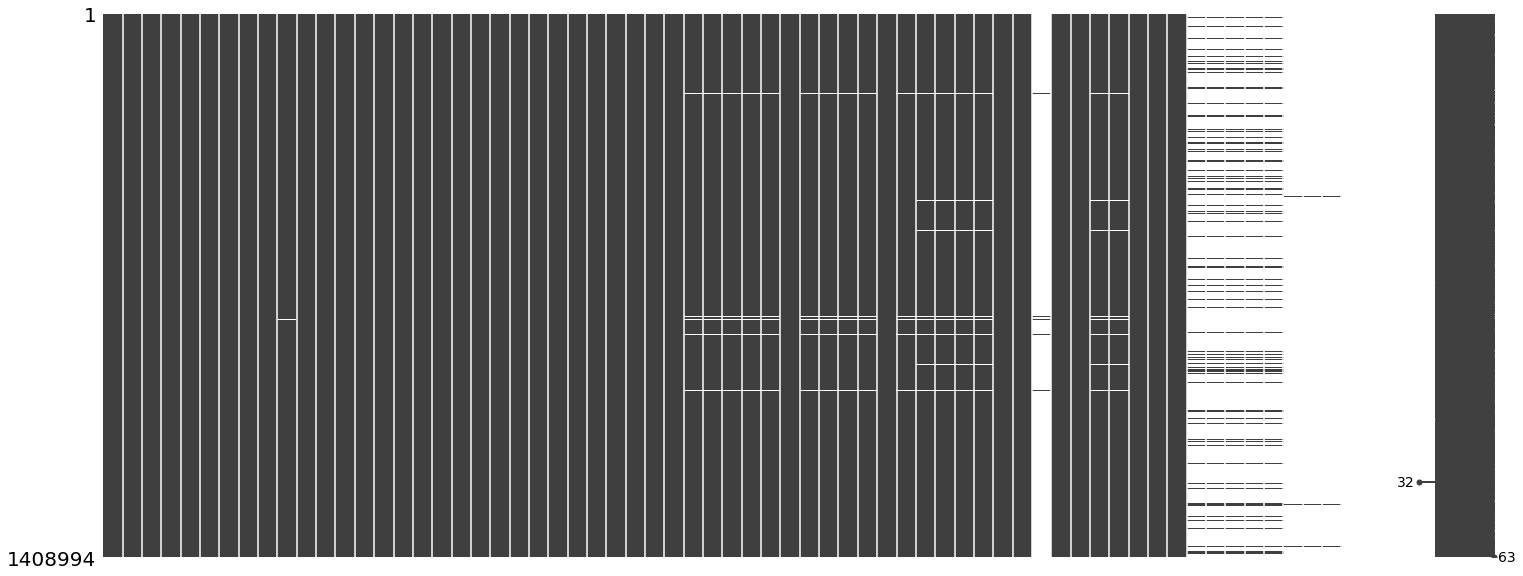

In [11]:
# Examinons l'état de la data
msno.matrix(df.sample(frac=0.25))

In [12]:
# fonction renvoyant le taux de remplissage d'une colonne col au sein d'une dataframe df donnée
def col_filling_rate(df, col):
    return 1 - df[col].isnull().sum() / len(df);

# Un dictionaire  associant chaque colonne avec son taux de remplissage au sein de la df 
rate_by_column = dict((col, col_filling_rate(df, col)) for col in df.columns.values)

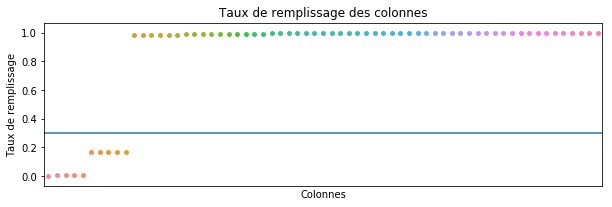

In [13]:
# plusieurs colonnes avec un taux de remplissage très faible

tmp=pd.DataFrame()
tmp['col']=list(rate_by_column.keys())
tmp['fill_ratio']=list(rate_by_column.values())
tmp.sort_values(by='fill_ratio',inplace=True)
plt.figure(figsize=(10,3))
sns.stripplot(x='col', y='fill_ratio', data=tmp)
plt.axhline(y=0.3)
plt.xticks([])
plt.xlabel('Colonnes')
plt.ylabel('Taux de remplissage')
plt.title('Taux de remplissage des colonnes')
plt.show()

In [14]:
# Suppression des colonnes vides à plus de 70% 
for (col, rate) in rate_by_column.items():
    if col in df and rate < 0.3:
        del df[col] 

# nouvelle taille
df.shape

(5635978, 55)

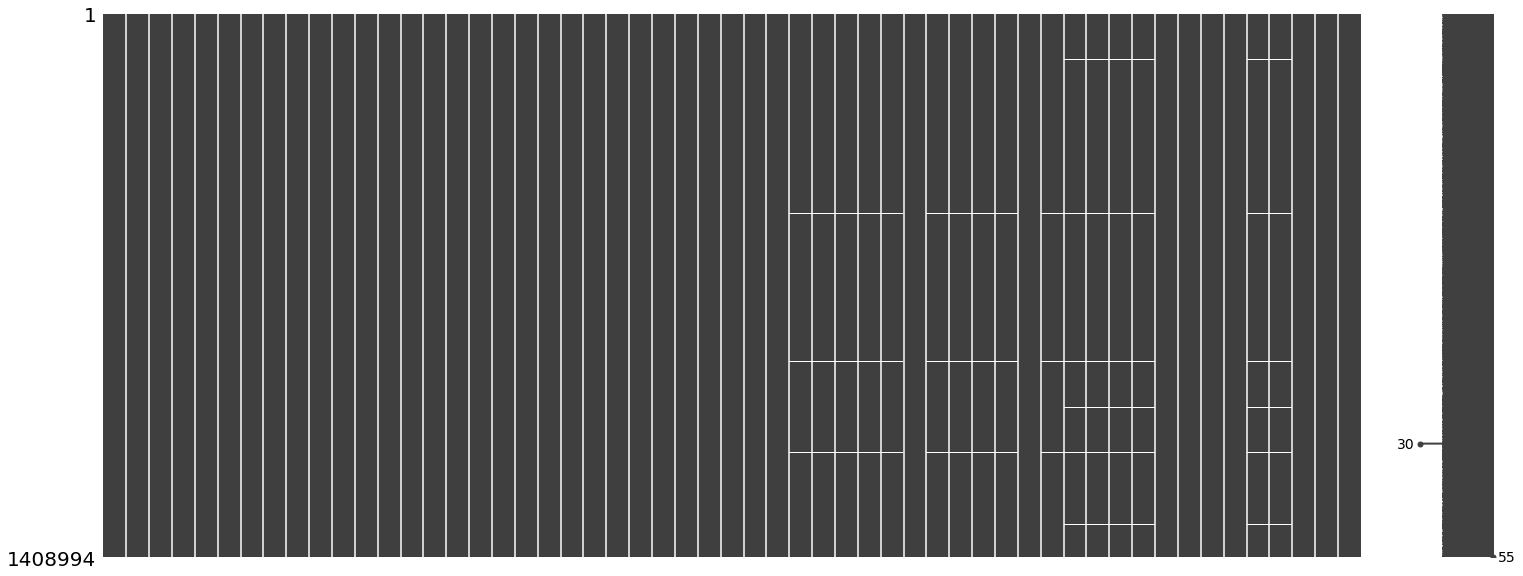

In [15]:
msno.matrix(df.sample(frac=0.25))

### Suppression des lignes correspondant aux vols annulés ou détournés

In [16]:
df.DEP_DELAY.isnull().sum()

63539

Au vue de notre ojectif (expliquer et prédir le retard), j'écarte les vols annulés ou détournés.

In [17]:
df = df[df.DIVERTED == 0]
df = df[df.CANCELLED == 0]
print(df.DEP_DELAY.isnull().sum(), 'valeur manquante pour la feature cible DEP_DELAY')

0 valeur manquante pour la feature cible DEP_DELAY


### Choix de features

En outre, s’agissant de construire un modèle de prédiction, je ne peux considerer que les informations
qu'un utilisateur peut fournir suffisament à l’avance, on revient plus tard sur les données manquantes

In [18]:
# on garde seulement l'heure pour la suite
df['CRS_DEP_TIME'] = (df['CRS_DEP_TIME'] / 100).astype(int)

In [19]:
df.DEP_DELAY.describe()

count    5.556195e+06
mean     8.917105e+00
std      3.964849e+01
min     -2.040000e+02
25%     -5.000000e+00
50%     -2.000000e+00
75%      6.000000e+00
max      2.149000e+03
Name: DEP_DELAY, dtype: float64

In [20]:
features = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'UNIQUE_CARRIER', 
            'ORIGIN_AIRPORT_ID','ORIGIN_CITY_NAME','CRS_DEP_TIME', 'DEP_DELAY']

In [21]:
df = df[features]
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,CRS_DEP_TIME,DEP_DELAY
0,1,6,3,AA,11298,"Dallas/Fort Worth, TX",11,-3.0
1,1,7,4,AA,11298,"Dallas/Fort Worth, TX",11,-4.0
2,1,8,5,AA,11298,"Dallas/Fort Worth, TX",11,-5.0
3,1,9,6,AA,11298,"Dallas/Fort Worth, TX",11,2.0
4,1,10,7,AA,11298,"Dallas/Fort Worth, TX",11,100.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5556195 entries, 0 to 5635977
Data columns (total 8 columns):
MONTH                int64
DAY_OF_MONTH         object
DAY_OF_WEEK          object
UNIQUE_CARRIER       object
ORIGIN_AIRPORT_ID    object
ORIGIN_CITY_NAME     object
CRS_DEP_TIME         int32
DEP_DELAY            float64
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 360.3+ MB


### Outliers

In [23]:
df.DEP_DELAY.describe()

count    5.556195e+06
mean     8.917105e+00
std      3.964849e+01
min     -2.040000e+02
25%     -5.000000e+00
50%     -2.000000e+00
75%      6.000000e+00
max      2.149000e+03
Name: DEP_DELAY, dtype: float64

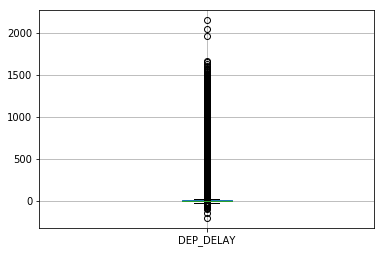

In [24]:
df.boxplot(column=['DEP_DELAY'])
plt.figure(figsize=(10,3))
plt.show()

On considérer comme valeur “aberrante” toute valeur v tel que : v > 120 ou v < -20

In [25]:
to_pkl(df, "data_with_outlier")

./pkl/data_with_outlier.pkl  a été enregistré


On supprime des lignes concernées

In [26]:
df = df[(-20 <= df.DEP_DELAY) & (df.DEP_DELAY <= 120)]
df.DEP_DELAY.describe()

count    5.436231e+06
mean     4.693605e+00
std      1.997697e+01
min     -2.000000e+01
25%     -5.000000e+00
50%     -2.000000e+00
75%      5.000000e+00
max      1.200000e+02
Name: DEP_DELAY, dtype: float64

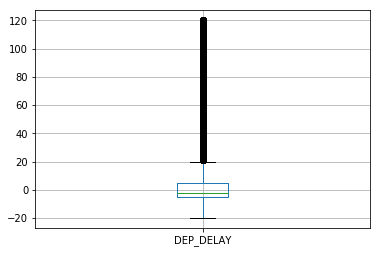

In [27]:
df.boxplot(column=['DEP_DELAY'])
plt.figure(figsize=(10,3))
plt.show()

### Doublons

In [28]:
# suppression des doublons
print("Avant :" , df.shape)
df.drop_duplicates(inplace=True)
# réarrangement des index suite à la suppression des doublons.
df = df.reset_index(drop=True)
print("Après :", df.shape)

Avant : (5436231, 8)
Après : (4666249, 8)


### Doublons dus au erreurs de types

In [29]:
# on vérifie s’il y’a  des éventuelles erreurs et doublons  dues au incohérences de type au sein de chaque feature retenue :

# fonction pour détecter si au sein de la meme colonne, plusieurs types sont présents
def suspicious_features(df):
    for feature in features:
        types = set([])
        if feature in df.columns:
            for v in df[feature]:
                types.add(type(v))
            message = " Vérification " + feature  + "  " + str(types)
            if(len(types) == 1):
                print(message +  " .... OK")
            else:
                print(message + "  .... WARN")

In [30]:
suspicious_features(df)

 Vérification MONTH  {<class 'int'>} .... OK
 Vérification DAY_OF_MONTH  {<class 'int'>, <class 'str'>}  .... WARN
 Vérification DAY_OF_WEEK  {<class 'int'>, <class 'str'>}  .... WARN
 Vérification UNIQUE_CARRIER  {<class 'str'>} .... OK
 Vérification ORIGIN_AIRPORT_ID  {<class 'int'>, <class 'str'>}  .... WARN
 Vérification ORIGIN_CITY_NAME  {<class 'str'>} .... OK
 Vérification CRS_DEP_TIME  {<class 'int'>} .... OK
 Vérification DEP_DELAY  {<class 'float'>} .... OK


In [31]:
# fonction renvoyant des valeurs suspectes (ne respectant pas le predicat passé en paramètre)
def suspicious_values(df, feature, predicate):
    return {v for v in df[feature] if not predicate(v) }    

In [32]:
# On met en évidence les valeurs qui sont sensés être numériques (même en typ str) alors qu'elles le sont pas 
suspicious_values(df, 'MONTH', lambda v: (type(str(v)) =="<class 'int'>") or str(v).isnumeric())

set()

In [33]:
suspicious_values(df, 'DAY_OF_MONTH', lambda v: (str(type(v)) =="<class 'int'>") or str(v).isnumeric())

set()

In [34]:
suspicious_values(df, 'DAY_OF_WEEK', lambda v: (str(type(v)) =="<class 'int'>") or str(v).isnumeric())

set()

In [35]:
suspicious_values(df, 'UNIQUE_CARRIER', lambda v: str(type(v)) =="<class 'str'>" and not str(v).isnumeric()) 

set()

In [36]:
suspicious_values(df, 'ORIGIN_AIRPORT_ID', lambda v: (str(type(v)) =="<class 'int'>") or str(v).isnumeric())

set()

In [37]:
suspicious_values(df, 'DEP_DELAY', lambda v: (str(type(v)) =="<class 'float'>") or str(v).isnumeric())

set()

In [38]:
# On s'assure que les features contiennent désormais des valeurs avec le bon type (on cast)

df[['DAY_OF_MONTH',
    'DAY_OF_WEEK',
    'ORIGIN_AIRPORT_ID']] = df[['DAY_OF_MONTH','DAY_OF_WEEK','ORIGIN_AIRPORT_ID']].apply(pd.to_numeric)

In [39]:
# re suppression des doublons après le "cast" des type
print("Avant :" , df.shape)
df.drop_duplicates(inplace=True)

# réarrangement des index suite à la suppression des doublons.
df = df.reset_index(drop=True)

print("Après :", df.shape)

Avant : (4666249, 8)
Après : (4568274, 8)


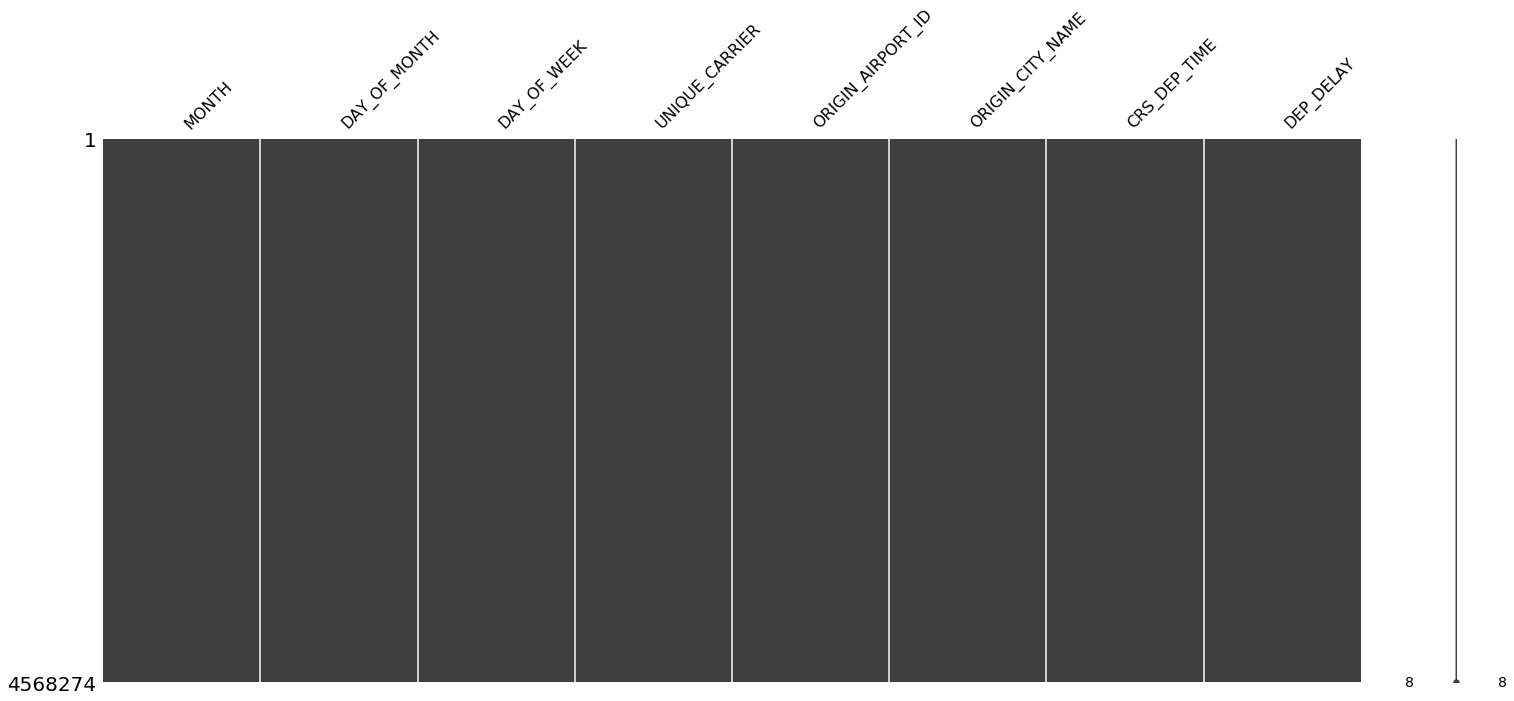

In [40]:
# la données est désormais prête
msno.matrix(df)

In [41]:
to_pkl(df, 'dataclean')

./pkl/dataclean.pkl  a été enregistré


In [3]:
#df = from_pkl('dataclean')

## Exploration et Analyse

In [42]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,CRS_DEP_TIME,DEP_DELAY
0,1,6,3,AA,11298,"Dallas/Fort Worth, TX",11,-3.0
1,1,7,4,AA,11298,"Dallas/Fort Worth, TX",11,-4.0
2,1,8,5,AA,11298,"Dallas/Fort Worth, TX",11,-5.0
3,1,9,6,AA,11298,"Dallas/Fort Worth, TX",11,2.0
4,1,10,7,AA,11298,"Dallas/Fort Worth, TX",11,100.0


In [43]:
print(len({x for x in df.ORIGIN_AIRPORT_ID}), 'aéroports de départ différents ')

311 aéroports de départ différents 


In [44]:
# fonction pour visualiser le retard moyen selon un critère donné

def plot_average_delay_by(df, column, description, plot = True, withbar = True, limit=None, asc = False):
    plt.figure(figsize=(20, 5))
    means = df.groupby(column)['DEP_DELAY'].mean()
    save_means = means
    if(limit is not None):
        means = means.sort_values(ascending=asc, inplace=False)
        means = means.head(limit)
        
    if plot:
        means.plot()
        plt.ylabel('Retard moyen en minutes')
        plt.xlabel(description)
        plt.title('Retard moyen par '+ description)
        plt.show()
    if withbar:
        plt.figure(figsize=(20, 5))
        means.plot.bar()
        plt.ylabel('Retard moyen')
        plt.xlabel(description)
        plt.title('Retard moyen par '+ description)
        plt.show()
    return save_means

In [45]:
# on remarque que les vols sont généralement plutot en avance !
df[['UNIQUE_CARRIER', 'DEP_DELAY']].groupby(['UNIQUE_CARRIER']).mean()

,DEP_DELAY
UNIQUE_CARRIER,
AA,6.319409
AS,-0.506750
B6,7.879362
DL,5.114498
EV,4.224585
F9,5.963115
HA,-0.913305
NK,7.067089
OO,3.106975


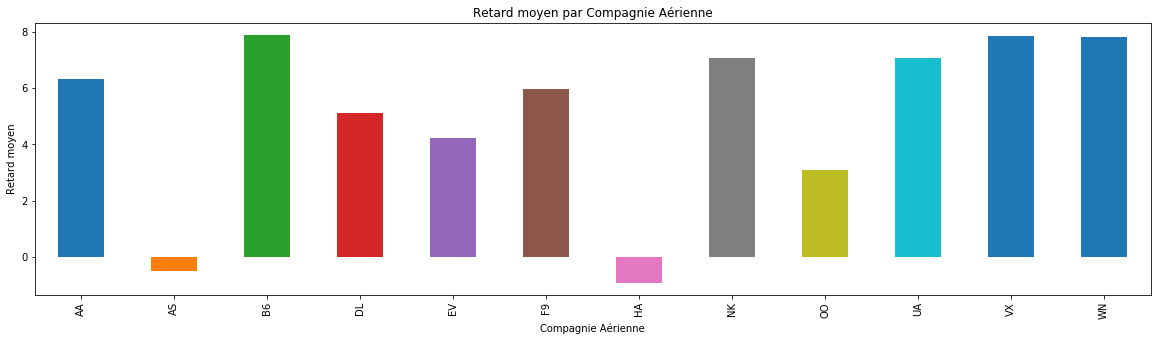

In [46]:
# le retard moyen par compagnie aerienne .
tmp = plot_average_delay_by(df, 'UNIQUE_CARRIER', 'Compagnie Aérienne',plot=False)

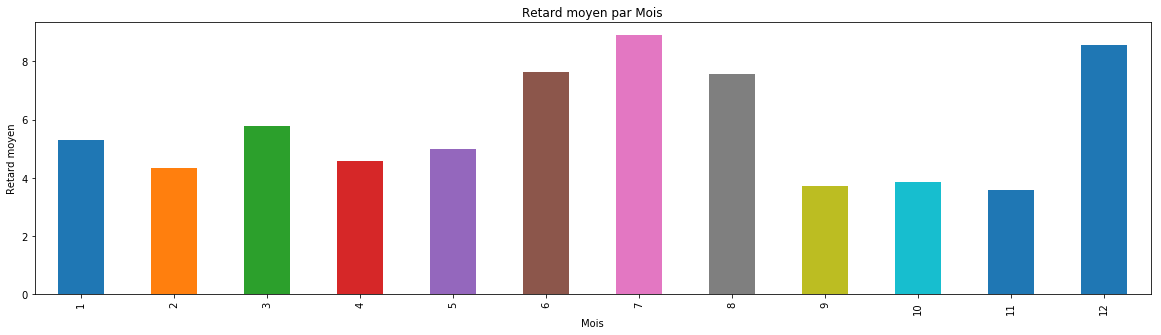

In [47]:
# le retard moyen par  mois.
tmp = plot_average_delay_by(df, 'MONTH', 'Mois', plot=False)

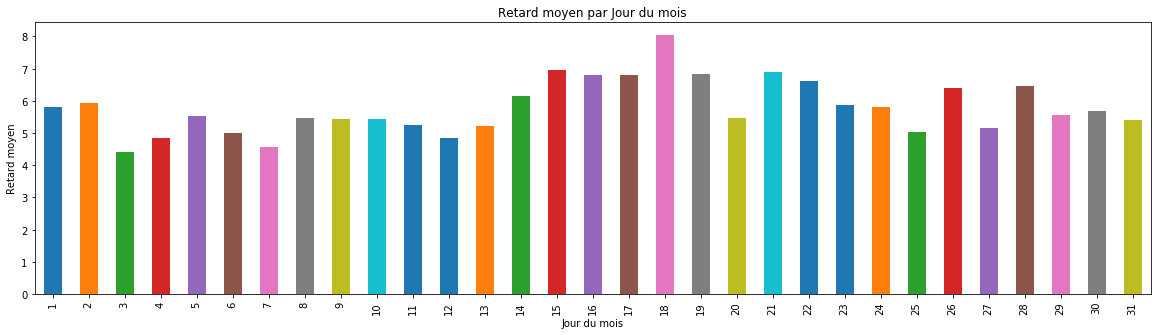

In [48]:
# le retard moyen par jour de mois.
tmp = plot_average_delay_by(df, 'DAY_OF_MONTH', 'Jour du mois',plot=False)

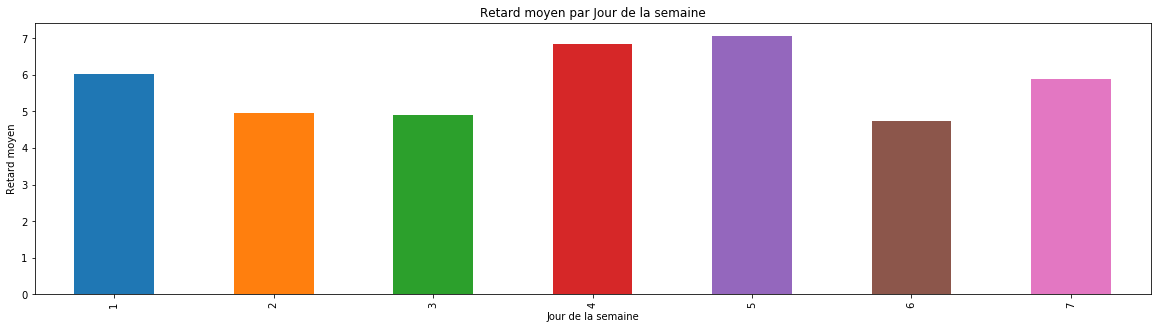

In [49]:
# le retard moyen par jour de la semaine.
tmp = plot_average_delay_by(df, 'DAY_OF_WEEK', 'Jour de la semaine',plot=False)

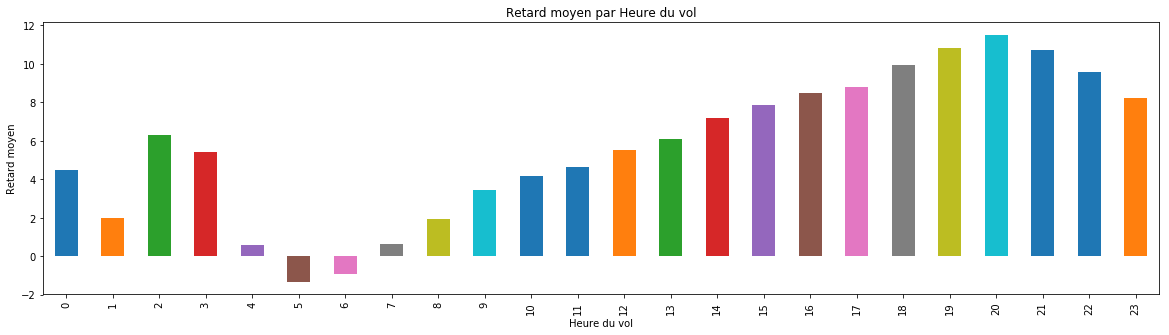

In [50]:
# le retard moyen par l'heure du vol
tmp = plot_average_delay_by(df, 'CRS_DEP_TIME', 'Heure du vol', plot=False)

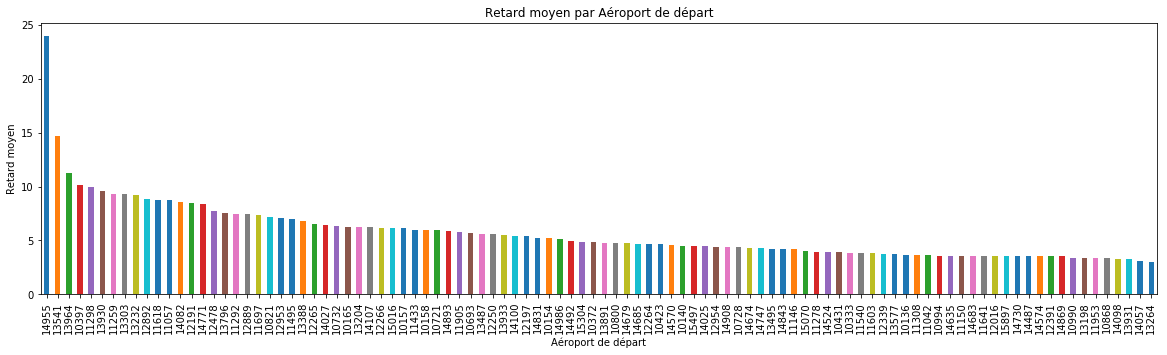

311

In [51]:
# le retard moyen par aeroport de départ : les Top 100 desc !
tmp = plot_average_delay_by(df, 'ORIGIN_AIRPORT_ID', 'Aéroport de départ', plot= False, limit = 100)
len(tmp)

In [53]:
print(len({x for x in df.UNIQUE_CARRIER}), 'compagnie aérienne différentes')

12 compagnie aérienne différentes


In [54]:
features

['MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'UNIQUE_CARRIER',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN_CITY_NAME',
 'CRS_DEP_TIME',
 'DEP_DELAY']

Toutes les variables retenues pour expliquer le retard sont des variables qualitatives

In [4]:
df = df.sample(10000)
df.shape

(10000, 8)

In [5]:
# sauvegarde aéroports et villes, agences et heures pour l'api 
to_pkl(df, "datasample")
airports_with_cities = (df["ORIGIN_CITY_NAME"] + ' - ' + df["ORIGIN_AIRPORT_ID"].map(str)).values
to_pkl(sorted({airport for airport in airports_with_cities}), 'airports_with_cities')
to_pkl(sorted({carrier for carrier in df['UNIQUE_CARRIER'].values}) ,'carriers')
to_pkl(sorted({'%02d' % (hour) for hour in df['CRS_DEP_TIME'].values}), 'hours')

./pkl/datasample.pkl  a été enregistré
./pkl/airports_with_cities.pkl  a été enregistré
./pkl/carriers.pkl  a été enregistré
./pkl/hours.pkl  a été enregistré


In [4]:
#df = from_pkl('datasample')

## Binarisation et standardisation

In [6]:
x_df = df[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK','UNIQUE_CARRIER','CRS_DEP_TIME','ORIGIN_AIRPORT_ID']]
X = pd.get_dummies(x_df.astype(np.str))

In [7]:
to_pkl(X, 'dummies')
to_pkl(X.columns.values, 'dummies_columns')

./pkl/dummies.pkl  a été enregistré
./pkl/dummies_columns.pkl  a été enregistré


In [8]:
y = df['DEP_DELAY'].values

In [9]:
to_pkl(y, 'target')

./pkl/target.pkl  a été enregistré


In [10]:
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X)
X = std_scale.transform(X)

In [11]:
to_pkl(std_scale, 'scaler')

./pkl/scaler.pkl  a été enregistré


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [13]:
to_pkl(X_train, 'X_train')
to_pkl(X_test, 'X_test')
to_pkl(y_test, 'y_test')
to_pkl(y_train, 'y_train')

./pkl/X_train.pkl  a été enregistré
./pkl/X_test.pkl  a été enregistré
./pkl/y_test.pkl  a été enregistré
./pkl/y_train.pkl  a été enregistré


In [47]:
# X_train = from_pkl('X_train')
# X_test = from_pkl('X_test')
# y_test = from_pkl('y_test')
# y_train = from_pkl('y_train')

In [14]:
from sklearn import metrics
def RMSE(y_test, y_predict):
    return "%.2f" % np.sqrt(metrics.mean_squared_error(y_test, y_predict))

def MAE(y_test, y_predict):
    return "%.2f" % metrics.mean_absolute_error(y_test, y_predict)

def pearson(y_test, y_predict):
    return "%.2f" % np.corrcoef(y_test, y_predict).item(1)

## Dummy model

In [45]:
# un dummy model pour se faire une idée !
dummy_model = dummy.DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
y_predict_ = dummy_model.predict(X_test)
print("RMSE:",RMSE(y_test, y_predict_), "MAE:", MAE(y_test, y_predict_))

RMSE: 20.50 MAE: 13.60


## Régression lineaire sans pénalité 

In [53]:
# une base line avec une regression lineare sans pénalisation.
rl_model = linear_model.LinearRegression()
rl_model.fit(X_train, y_train)
y_predict_ = rl_model.predict(X_test)
print("RMSE:", RMSE(y_test, y_predict_), "MAE:", MAE(y_test, y_predict_))

RMSE: 20.43 MAE: 13.53


## Régression Ridge

In [15]:
# chercher empiriquement alpha qui minimise MAE pour une régression ridge
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, HuberRegressor, Lars, SGDRegressor

def runModel(model, alphas, loss):    
    
    m = model()
    coefs = []
    errors = []
    loss_name = loss.__name__ 
    
    for a in alphas:
        m.set_params(alpha=a)
        m.fit(X_train, y_train)
        coefs.append(m.coef_)
        print('alpha:', round(a,2), '  ' + loss_name + ': ', loss(y_test, m.predict(X_test)))
        errors.append(loss(y_test, m.predict(X_test)))
    
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(121)
    ax = plt.gca()
    ax.plot(alphas, errors)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel(loss_name)
    plt.title(model.__name__)

    plt.subplot(122)
    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    plt.xlabel('alpha')
    plt.ylabel('Coefs')
    plt.title(model.__name__)
    plt.show
    

Pour la valeur de alpha 6345.77 nous avons un model ridge avec MAE minimale de 13.11

alpha: 1.0   MAE:  13.33
alpha: 2.99   MAE:  13.33
alpha: 8.93   MAE:  13.33
alpha: 26.66   MAE:  13.33
alpha: 79.66   MAE:  13.32
alpha: 237.99   MAE:  13.29
alpha: 710.99   MAE:  13.23
alpha: 2124.09   MAE:  13.14
alpha: 6345.77   MAE:  13.11
alpha: 18958.09   MAE:  13.26
alpha: 56637.65   MAE:  13.43
alpha: 169205.98   MAE:  13.53
alpha: 505505.91   MAE:  13.57
alpha: 1510207.95   MAE:  13.59
alpha: 4511773.33   MAE:  13.59
alpha: 13479003.68   MAE:  13.60
alpha: 40268765.1   MAE:  13.60
alpha: 120303657.48   MAE:  13.60
alpha: 359409332.95   MAE:  13.60
alpha: 1073741824.0   MAE:  13.60


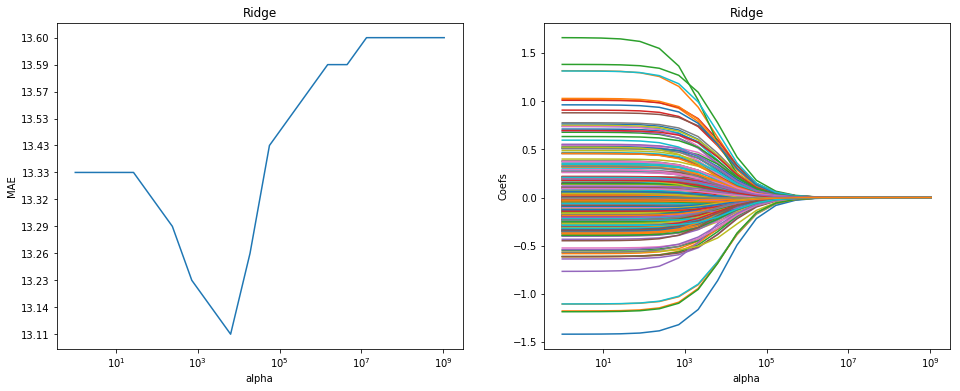

In [16]:
runModel(
    Ridge, 
    np.logspace(0, 30, num=20, endpoint=True, base=2, dtype=None),
    MAE
)

Cela se confirme, la valeur de alpha = 6345.77 donne un RMSE minimale de 20.05 pour le Ridge : 

alpha: 1.0   RMSE:  20.44
alpha: 2.99   RMSE:  20.44
alpha: 8.93   RMSE:  20.44
alpha: 26.66   RMSE:  20.43
alpha: 79.66   RMSE:  20.42
alpha: 237.99   RMSE:  20.38
alpha: 710.99   RMSE:  20.29
alpha: 2124.09   RMSE:  20.15
alpha: 6345.77   RMSE:  20.05
alpha: 18958.09   RMSE:  20.14
alpha: 56637.65   RMSE:  20.32
alpha: 169205.98   RMSE:  20.43
alpha: 505505.91   RMSE:  20.48
alpha: 1510207.95   RMSE:  20.49
alpha: 4511773.33   RMSE:  20.50
alpha: 13479003.68   RMSE:  20.50
alpha: 40268765.1   RMSE:  20.50
alpha: 120303657.48   RMSE:  20.50
alpha: 359409332.95   RMSE:  20.50
alpha: 1073741824.0   RMSE:  20.50


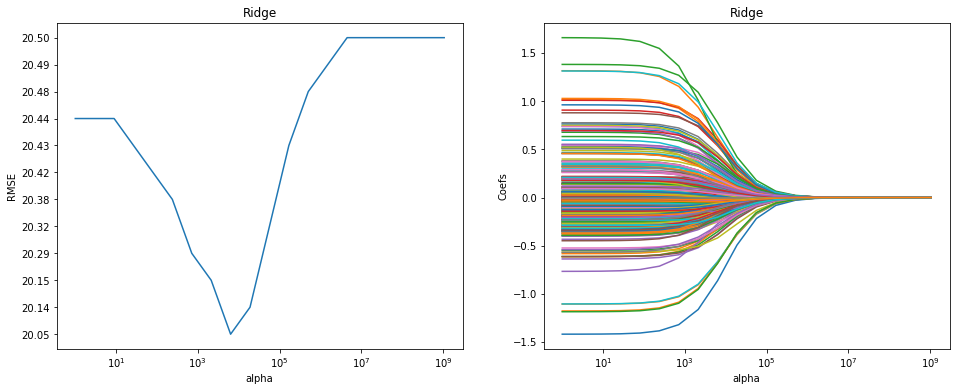

In [17]:
runModel(
    Ridge, 
    np.logspace(0, 30, num=20, endpoint=True, base=2, dtype=None),
    RMSE
)

## Régression Lasso

La valeur alpha = 0.28 donne un MAE minimale de 13.04 pour le Lasso

alpha: 0.03   MAE:  13.23
alpha: 0.05   MAE:  13.20
alpha: 0.06   MAE:  13.17
alpha: 0.09   MAE:  13.12
alpha: 0.13   MAE:  13.08
alpha: 0.19   MAE:  13.04
alpha: 0.28   MAE:  13.04
alpha: 0.4   MAE:  13.08
alpha: 0.58   MAE:  13.16
alpha: 0.83   MAE:  13.32
alpha: 1.2   MAE:  13.51
alpha: 1.73   MAE:  13.59
alpha: 2.49   MAE:  13.60
alpha: 3.59   MAE:  13.60
alpha: 5.16   MAE:  13.60
alpha: 7.44   MAE:  13.60
alpha: 10.71   MAE:  13.60
alpha: 15.43   MAE:  13.60
alpha: 22.22   MAE:  13.60
alpha: 32.0   MAE:  13.60


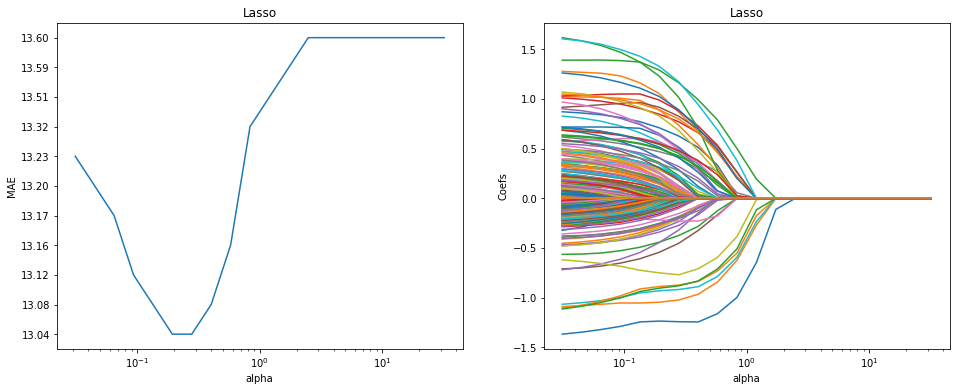

In [18]:
# prendre la plus grande valeur si plateau
runModel(
    Lasso, 
    np.logspace(-5, 5, num=20, endpoint=True, base=2, dtype=None),
    MAE
)

## Régression Elastic net

Le Elastic net sans surprise ne donne pas un résultat meilleur  dans ce cas, étant une combinaison linéaire du Ridge et Lasso


La valeur de alpha = 0.4 (associé à la valeur 0.15 du l1_ratio par défaut) donne un MAE minimale de 13.05

alpha: 0.03   MAE:  13.26
alpha: 0.05   MAE:  13.23
alpha: 0.06   MAE:  13.20
alpha: 0.09   MAE:  13.16
alpha: 0.13   MAE:  13.12
alpha: 0.19   MAE:  13.08
alpha: 0.28   MAE:  13.06
alpha: 0.4   MAE:  13.05
alpha: 0.58   MAE:  13.09
alpha: 0.83   MAE:  13.17
alpha: 1.2   MAE:  13.30
alpha: 1.73   MAE:  13.45
alpha: 2.49   MAE:  13.57
alpha: 3.59   MAE:  13.60
alpha: 5.16   MAE:  13.60
alpha: 7.44   MAE:  13.60
alpha: 10.71   MAE:  13.60
alpha: 15.43   MAE:  13.60
alpha: 22.22   MAE:  13.60
alpha: 32.0   MAE:  13.60


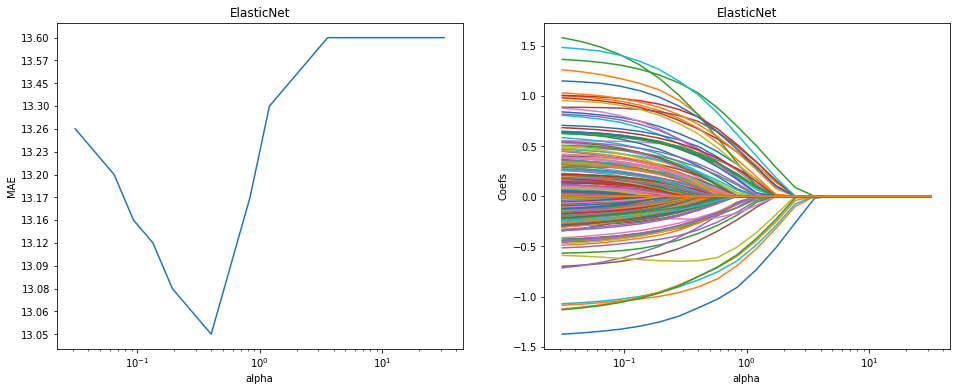

In [19]:
# le l1_ratio
runModel(
    ElasticNet, 
    np.logspace(-5, 5, num=20, endpoint=True, base=2, dtype=None),
    MAE
)

## Comparaison des modèles avec validation croisée

In [20]:
from sklearn import dummy, linear_model

models = {
    'dummy':{
        'model': dummy.DummyRegressor(strategy='mean'),
        'param_grid':{}
    },
    'linear_regression':{
        'model': linear_model.LinearRegression(),
        'param_grid':{}
    },
    'ridge':{
        'model': linear_model.Ridge(),
        'param_grid':{'alpha':[6345.77]}
    },
    'lasso':{
        'model': linear_model.Lasso(),
        'param_grid':{'alpha':[0.28]}
    },
    
    'SGDRegressor':{
    'model': linear_model.SGDRegressor(),
    'param_grid':{'penalty':['l1','l2','elasticnet'],
                  'l1_ratio':[0.1, 0.3, 0.6], 
                  'alpha':[6345.77, 0.28, 0.4],
                  'loss':['squared_loss', 'huber', 'epsilon_insensitive'], 
                  'max_iter':[1000]}
    }
}

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import time

def cross_validation_engine(X_train, y_train, X_test, y_test):
    
    result = pd.DataFrame(columns=['Model','RMSE','MAE','Pearson','Parameter'])

    for i, key in enumerate(models):
        start = time.time()
        model = models[key]['model']
        param_grid = models[key]['param_grid']
        
        if key in ['dummy','linear_regression']: # pas besoin de cross validation
            model.fit(X_train, y_train)
            y_predict = model.predict(X_test)
            result.loc[i] = [key, RMSE(y_test, y_predict), MAE(y_test, y_predict), pearson(y_test, y_predict), ""]
        else:
            pass
            gcv = GridSearchCV(model, param_grid, scoring = 'neg_mean_absolute_error', cv=5, refit=True, verbose=2)
            gcv.fit(X_train, y_train)
            model = gcv.best_estimator_
            y_predict = model.predict(X_test)   
            best_params = model.get_params()
            models[key]['model'] = model
            result.loc[i] = [key, 
                             RMSE(y_test, y_predict), 
                             MAE(y_test, y_predict), 
                             pearson(y_test, y_predict), 
                             {param : best_params[param] for param in param_grid.keys()}]
        end = time.time()
        print(key, ' terminé en ', round(end - start, 2), ' secondes')
        #print(key, ' best params ', str({param : best_params[param] for param in param_grid.keys()})
    return result   

In [22]:
result_models = cross_validation_engine(X_train, y_train, X_test, y_test)

dummy  terminé en  0.01  secondes
linear_regression  terminé en  0.33  secondes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=6345.77 ...................................................
[CV] .................................... alpha=6345.77, total=   0.0s
[CV] alpha=6345.77 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................................... alpha=6345.77, total=   0.0s
[CV] alpha=6345.77 ...................................................
[CV] .................................... alpha=6345.77, total=   0.0s
[CV] alpha=6345.77 ...................................................
[CV] .................................... alpha=6345.77, total=   0.0s
[CV] alpha=6345.77 ...................................................
[CV] .................................... alpha=6345.77, total=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


ridge  terminé en  0.71  secondes
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.28 ......................................................
[CV] ....................................... alpha=0.28, total=   0.1s
[CV] alpha=0.28 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ....................................... alpha=0.28, total=   0.1s
[CV] alpha=0.28 ......................................................
[CV] ....................................... alpha=0.28, total=   0.0s
[CV] alpha=0.28 ......................................................
[CV] ....................................... alpha=0.28, total=   0.0s
[CV] alpha=0.28 ......................................................
[CV] ....................................... alpha=0.28, total=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


lasso  terminé en  0.97  secondes
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1 
[CV]  alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1, total=  28.7s
[CV] alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.7s remaining:    0.0s


[CV]  alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1, total=  28.6s
[CV] alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1 
[CV]  alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1, total=  28.6s
[CV] alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1 
[CV]  alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1, total=  28.2s
[CV] alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1 
[CV]  alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1, total=  28.5s
[CV] alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2, total=  15.4s
[CV] alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2, total=  14.9s
[CV] alpha=6345.77, l1_ratio=0

[CV]  alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l1, total=  27.5s
[CV] alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l1 
[CV]  alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l1, total=  25.4s
[CV] alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l1 
[CV]  alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l1, total=  24.9s
[CV] alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2, total=  14.2s
[CV] alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2, total=  15.3s
[CV] alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2, total=  15.2s
[CV] alpha=6345.77, l1_ratio=0

[CV]  alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l1, total=  29.5s
[CV] alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l1 
[CV]  alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l1, total=  29.6s
[CV] alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2, total=  15.0s
[CV] alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2, total=  15.9s
[CV] alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2, total=  15.6s
[CV] alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=6345.77, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2, total=  15.6s
[CV] alpha=6345.77, l1_ratio=0

[CV]  alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l1, total=  30.2s
[CV] alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2, total=  14.0s
[CV] alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2, total=  13.4s
[CV] alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2, total=  12.1s
[CV] alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2, total=  13.5s
[CV] alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=l2, total=  13.3s
[CV] alpha=0.28, l1_ratio=0.1, loss=squared_loss, max_iter=1000

[CV]  alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2, total=   6.8s
[CV] alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2, total=   7.0s
[CV] alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2, total=   6.8s
[CV] alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=l2, total=   6.9s
[CV] alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.2s
[CV] alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.28, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.3s
[CV] alpha=0.28, l1_ratio=0.3, 

[CV]  alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2, total=   6.9s
[CV] alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2 
[CV]  alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=l2, total=   6.8s
[CV] alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.5s
[CV] alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.4s
[CV] alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.4s
[CV] alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.28, l1_ratio=0.6, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.4s

[CV]  alpha=0.4, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  15.1s
[CV] alpha=0.4, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.4, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.2s
[CV] alpha=0.4, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.4, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.3s
[CV] alpha=0.4, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=elasticnet 
[CV]  alpha=0.4, l1_ratio=0.1, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.3s
[CV] alpha=0.4, l1_ratio=0.1, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.1, loss=huber, max_iter=1000, penalty=l1, total=  13.6s
[CV] alpha=0.4, l1_ratio=0.1, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.1, loss=huber, max_iter=1000, penalty=l1, total=  13.4s
[CV] alpha=0.4, l1_ratio=0.1, loss=huber, 

[CV]  alpha=0.4, l1_ratio=0.3, loss=squared_loss, max_iter=1000, penalty=elasticnet, total=  14.6s
[CV] alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1, total=  13.5s
[CV] alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1, total=  13.5s
[CV] alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1, total=  13.5s
[CV] alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1, total=  13.5s
[CV] alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l1, total=  13.5s
[CV] alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=1000, penalty=l2 ..
[CV]  alpha=0.4, l1_ratio=0.3, loss=huber, max_iter=100

[CV]  alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l1, total=  13.7s
[CV] alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l1, total=  14.5s
[CV] alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l1 ..
[CV]  alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l1, total=  13.7s
[CV] alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l2 ..
[CV]  alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l2, total=   6.9s
[CV] alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l2 ..
[CV]  alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l2, total=   6.8s
[CV] alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l2 ..
[CV]  alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l2, total=   6.9s
[CV] alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l2 ..
[CV]  alpha=0.4, l1_ratio=0.6, loss=huber, max_iter=1000, penalty=l2, 

[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed: 116.4min finished


SGDRegressor  terminé en  6990.04  secondes


In [28]:
#to_pkl(result_models, "result_models")
#to_pkl(models['SGDRegressor']['model'], 'best_model')

./pkl/result_models.pkl  a été enregistré


In [66]:
result_models

,Model,RMSE,MAE,Pearson,Parameter
0,dummy,20.50,13.60,0.00,
1,linear_regression,20.43,13.53,0,
2,ridge,20.05,13.11,0.21,{'alpha': 6345.77}
3,lasso,20.11,13.04,0.20,{'alpha': 0.28}
4,SGDRegressor,21.50,10.95,0.21,"{'penalty': 'l2', 'l1_ratio': 0.3, 'alpha': 0...."


### Le meilleur model fourni par la validation croisée

C'est l'optimisation d'un contrast composé d'une fonction de perte de type epsilon senstive et une pénalité de type L2 combiné avec L1 avec un ratio de 0.3

In [64]:
best_model = from_pkl('best_model')
print('alpha: ', best_model.alpha, 
      '\npenalty:', best_model.penalty, 
      '\nloss:', best_model.loss, 
      '\nl1_ratio:', best_model.l1_ratio)

alpha:  0.28 
penalty: l2 
loss: epsilon_insensitive 
l1_ratio: 0.3


Ce modèle est sauvegardé sous format pkl, avec son scaler associé, et sont utilisés pour faire la prédiction du retard dans l'api

<strong>https://op-proj4.herokuapp.com/flight-delays-prediction</strong>